In [1]:
# import opencv-python 
import sleap
import json
import os
from pprint import pprint

In [2]:
sleap.disable_preallocation()
sleap.system_summary()
sleap.versions()

GPUs: 2/2 available
  Device: /physical_device:GPU:0
         Available: True
        Initalized: False
     Memory growth: True
  Device: /physical_device:GPU:1
         Available: True
        Initalized: False
     Memory growth: True
SLEAP: 1.3.3
TensorFlow: 2.7.0
Numpy: 1.19.5
Python: 3.7.12
OS: Linux-5.15.0-86-generic-x86_64-with-debian-bullseye-sid


## Load MARS data
First, we'll need to convert the manifest files into something that SLEAP can read -- easiest is probably COCO


In [3]:
# label_manifest = '/home/kevin/Downloads/OpenField_Data/output_open_paws.manifest'
label_json = '/home/kevin/Downloads/OpenField_Data/processed_keypoints_open_combined_.json'


In [4]:
# # manifest version
# # open and start parsing file
# with open(label_manifest) as fid:
#     anns = []
#     for line in fid:
#         anns.append(json.loads(line))
# nodes = [result['label'].lstrip() for result in eval(anns[0]['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']]


# json version
with open(label_json) as file:
    anns = eval(file.read())
nodes = anns[0]['ann_label']

# initialize the skeleton
skeleton = sleap.Skeleton()
skeleton.add_nodes(nodes)



In [ ]:
# connect some stuff. probably not necessary
skeleton.add_edge('nose','throat')
skeleton.add_edge('throat','body center')
skeleton.add_edge('body center','right hip')
skeleton.add_edge('body center','left hip')
skeleton.add_edge('right hip','tail base')
skeleton.add_edge('left hip','tail base')
skeleton.add_edge('tail base','tail mid')
skeleton.add_edge('tail mid','tail tip')

In [5]:

data_path = '/home/kevin/Downloads/OpenField_Data/images/'
# manifest version
# frame_names = [data_path + os.path.split(ann['source-ref'])[-1] for ann in anns if 'annotatedResult' in ann.keys()]
# # json version
frame_names = [data_path + os.path.split(ann['image'])[-1] for ann in anns]

video = sleap.Video.from_image_filenames(filenames=frame_names)


In [ ]:
# manifest version

# create a labeled frame iterator
lab_frame = []
img_id = 0
# iterate through the images
for ann in anns:

    # if the file wasn't annotated, skip
    if 'annotatedResult' not in ann.keys():
        continue

    # get the image name
    img_name = os.path.split(ann['source-ref'])[-1]
    img_id = video.get_idx_from_filename(data_path+img_name)
    
    instances = []
    for w, worker_result in enumerate(ann['annotatedResult']['annotationsFromAllWorkers']):
        # results for each worker are embeded as a string
        annot = eval(worker_result['annotationData']['content'])['annotatedResult']

        keypoint_dict = {item['label'].lstrip():sleap.instance.Point(x=item['x'], y=item['y'])
                         for item in annot['keypoints']}
        
        # append the list
        instance = sleap.Instance(skeleton=skeleton, points=keypoint_dict)
        instances.append(instance)

        labeled_frame = sleap.LabeledFrame(video=video, frame_idx = img_id, instances=instances)

    # put the instances into the labeled frame list
    lab_frame.append(labeled_frame)

In [6]:
# json version

# create a labeled frame iterator
lab_frame = []
# iterate through the images
for ann in anns:

    height = ann['height']
    width = ann['width']

    # get the image name
    img_name = os.path.split(ann['image'])[-1]
    img_id = video.get_idx_from_filename(data_path+img_name)
    
    instances = []
    keypoint_dict = {ann_label:sleap.instance.Point(x=ann['ann_black']['X'][0][ii]*width,y=ann['ann_black']['Y'][0][ii]*height)
                     for ii,ann_label in enumerate(ann['ann_label'])}
    instance = sleap.Instance(skeleton=skeleton, points=keypoint_dict)
    instances.append(instance)

    labeled_frame = sleap.LabeledFrame(video=video, frame_idx=img_id, instances=instances)

    # put the instances into the labeled frame list
    lab_frame.append(labeled_frame)

In [7]:
output_labels = sleap.Labels(lab_frame)

In [8]:
video[1000]

array([[[[23, 23, 23],
         [25, 25, 25],
         [32, 32, 32],
         ...,
         [93, 93, 93],
         [79, 79, 79],
         [58, 58, 58]],

        [[23, 23, 23],
         [25, 25, 25],
         [33, 33, 33],
         ...,
         [73, 73, 73],
         [58, 58, 58],
         [41, 41, 41]],

        [[23, 23, 23],
         [25, 25, 25],
         [33, 33, 33],
         ...,
         [52, 52, 52],
         [39, 39, 39],
         [30, 30, 30]],

        ...,

        [[73, 73, 73],
         [73, 73, 73],
         [72, 72, 72],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[73, 73, 73],
         [73, 73, 73],
         [72, 72, 72],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[73, 73, 73],
         [73, 73, 73],
         [72, 72, 72],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]]], dtype=uint8)

['nose', 'throat', 'body center', 'right ear', 'left ear', 'right hip', 'left hip', 'tail base', 'tail mid', 'tail tip', 'right front paw tip', 'right front paw right', 'right front paw left', 'right front paw base', 'left front paw tip', 'left front paw right', 'left front paw left', 'left front paw base', 'right hind paw tip', 'right hind paw right', 'right hind paw left', 'right hind paw base', 'left hind paw tip', 'left hind paw right', 'left hind paw left', 'left hind paw base']


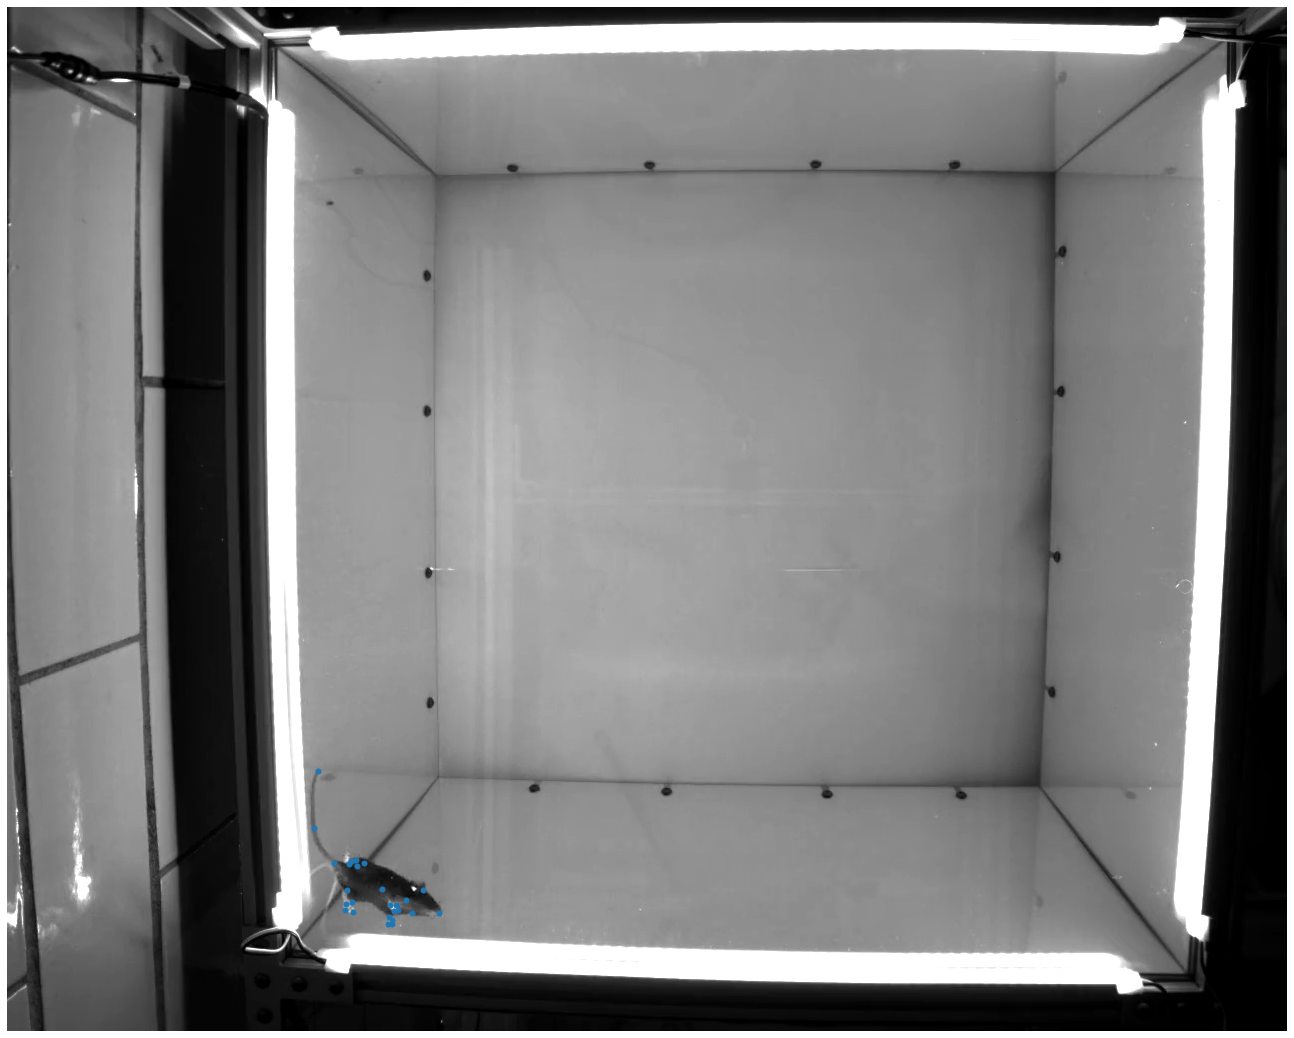

In [11]:
import random

for labeled in random.choices(output_labels, k = 1):
    labeled.plot()
    names = [node_point[0].name for node_point in labeled.instances[0].nodes_points]
    print(names)


In [ ]:
labeled.instances[0].nodes_points

In [ ]:
missing_frames = []


for labeled_frame in output_labels:
    names = [node_point[0].name for node_point in labeled_frame.instances[0].nodes_points]
    if len(names) < 16:
        missing_frames.append(labeled_frame.video.backend.filename)


In [ ]:
output_labels[1000]

In [21]:
output_labels.save('processed_open_combined.slp',with_images=True)

In [23]:
!sleep-train '~/Downloads/baseline_large_rf.single.json' processed_open_combined.slp

/bin/bash: sleep-train: command not found


In [22]:
os.getcwd()

'/home/kevin/git/Work_Tools/three_dee_reconstruction'

In [ ]:
#json version
missing_dict = {}
missing_count = 0

for ann in anns:

    height = ann['height']
    width = ann['width']

    missing_list = [ann_label for ii,ann_label in enumerate(ann['ann_label'])
                    if (ann['ann_black']['X'][0][ii] == 0) and (ann['ann_black']['Y'][0][ii] == 0)]

    if len(missing_list) > 0:
        missing_dict[ann['image']] = missing_list 
    missing_count += len(missing_list)

    
    

In [ ]:
for frame in output_labels:
    frame.

In [ ]:
# manifest version
missing_count = 0
missing_dict = dict()

nodes = [result['label'].lstrip() for result in eval(anns[0]['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']]

for ann in anns:
    # keypoints
    keypoints = eval(ann['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']
    
    missing_list = [keypoint['label'].lstrip() for keypoint in keypoints if (keypoint['x'] == 0) and (keypoint['y'] == 0)]

    if len(missing_list) > 0:
        missing_dict[ann['image']] = missing_list 
    missing_count += len(missing_list)



In [12]:
import pandas as pd
import numpy as np

In [13]:
keypoint_pd = pd.DataFrame()
for ii_ann,ann in enumerate(anns):
    # skip anything without annotations
    # if 'annotatedResult' not in ann.keys():
    #     continue

    # keypoints = eval(ann['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']
    # kp_dict = {kp['label'].lstrip():[[kp['x'],kp['y']]] for kp in keypoints}

    kp_dict = {label:[[ann['ann_black']['X'][0][ii],ann['ann_black']['Y'][0][ii]]] for ii,label in enumerate(ann['ann_label'])}
    kp_dict['filename'] = ann['image'].split('/')[-1]
    keypoint_pd = pd.concat([keypoint_pd, pd.DataFrame.from_dict(kp_dict)], ignore_index=True)



In [14]:
print([file[-50:] for file in keypoint_pd.loc[keypoint_pd.isna().any(axis=1)]['filename'][:5]])

['60gm__24108332__20230330_121816065_1024_012071.jpg']


In [20]:
sleap.nn.training.CentroidConfmapsModelTrainer()

'Basler_acA1300-60gm__24108332__20230502_152502407_1024_021109.jpg'